To Convert images to size 28x28 and grayscale :-

In [1]:
#!/usr/bin/env python
# coding: utf-8

"""Created on Sat May 30 09:06:40 2020

@author: PRAGYA"""

import os
import PIL
import glob
print('Pillow Version:', PIL.__version__)
from PIL import Image
from PIL import ImageOps
root_dir = "C:\\Users\\PRAGYA\\Desktop\\Dataset"
cnt=0
classes_dir = ['MBkSl', 'MBkSt', 'MWSl', 'MWSt','WBkSl', 'WBkSt', 'WWSl', 'WWSt']
for cls in classes_dir:
    src = root_dir +'//'+cls
    data_path = os.path.join(src,'*g')
    files = glob.glob(data_path)
    for name in files:
        img=Image.open(name,"r")
        img=img.resize((28,28))
        img=img.convert('L')
        cnt+=1
        img.save(name)
print(cnt)

Pillow Version: 9.4.0
125


Preparing and Labelling dataset :-

In [2]:
import numpy as np
import os
import PIL
import glob
from numpy import asarray
print('Pillow Version:',PIL.__version__)
from PIL import Image
trainY=np.zeros(shape=(125))
trainY.fill(-1)
trainX=np.zeros(shape=(125,28,28))
i=0
rev_map={0:'MBkSl', 1:'MBkSt', 2:'MWSl', 3:'MWSt', 4:'WBkSl', 5:'WBkSt', 6:'WWSl', 7:'WWSt'}
_map = {v: k for k, v in rev_map.items()}
root_dir = "C:\\Users\\PRAGYA\\Desktop\\Dataset"
classes_dir = ['MBkSl', 'MBkSt', 'MWSl', 'MWSt','WBkSl', 'WBkSt', 'WWSl', 'WWSt']
for cls in classes_dir:
    src = root_dir +'//'+cls
    data_path = os.path.join(src,'*g')
    files = glob.glob(data_path)
    for name in files:
        img=Image.open(name,"r")
        trainX[i]=img
        trainY[i]=_map[cls]
        i+=1
print(trainY)

Pillow Version: 9.4.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.
 7. 7. 7. 7. 7.]


Writing code for the ACGAN model :-

In [4]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
#from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from keras.models import load_model
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=8):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=8):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 384 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((7, 7, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# load images
def load_real_samples():
	# load dataset
	#(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainY.shape)
	return [X, trainY]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=8):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=32):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(32):
		# define subplot
		pyplot.subplot(4, 8, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'Final_generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'Final_Model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20000, n_batch=25):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(86000, n_steps, 1):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 100) == 0:
			summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = load_model('Final_Model_86000.h5')#define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)



(125, 28, 28) (125,)
1/1 [==============================] - 0s 175ms/step
>86001, dr[0.846,2.980], df[3.544,3.043], g[0.692,2.079]
1/1 [==============================] - 0s 47ms/step
>86002, dr[0.221,2.575], df[0.821,4.963], g[0.700,2.074]
1/1 [==============================] - 0s 47ms/step
>86003, dr[1.278,3.906], df[0.166,2.405], g[0.697,2.082]
1/1 [==============================] - 0s 47ms/step
>86004, dr[0.664,3.226], df[0.992,3.287], g[0.693,2.079]
1/1 [==============================] - 0s 47ms/step
>86005, dr[0.420,2.305], df[0.299,4.217], g[0.695,2.077]
1/1 [==============================] - 0s 47ms/step
>86006, dr[0.235,2.165], df[0.066,1.457], g[0.688,2.068]
1/1 [==============================] - 0s 47ms/step
>86007, dr[0.327,2.654], df[0.202,1.574], g[0.679,2.076]
1/1 [==============================] - 0s 47ms/step
>86008, dr[0.140,1.653], df[0.116,1.058], g[0.671,2.096]
1/1 [==============================] - 0s 47ms/step
>86009, dr[0.469,1.794], df[0.171,0.837], g[0.650,2.08

C:\Users\PRAGYA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: Final_generated_plot_86500.png and Final_Model_86500.h5
1/1 [==============================] - 0s 47ms/step
>86501, dr[0.002,0.151], df[0.000,0.000], g[7.637,0.388]
1/1 [==============================] - 0s 47ms/step
>86502, dr[0.001,0.558], df[0.000,0.000], g[5.163,0.245]
1/1 [==============================] - 0s 94ms/step
>86503, dr[0.000,0.005], df[0.000,0.000], g[4.014,0.617]
1/1 [==============================] - 0s 94ms/step
>86504, dr[0.006,0.001], df[0.002,0.003], g[3.937,0.211]
1/1 [==============================] - 0s 94ms/step
>86505, dr[0.006,0.025], df[0.000,0.000], g[3.799,0.292]
1/1 [==============================] - 0s 71ms/step
>86506, dr[0.001,0.439], df[0.000,0.000], g[3.508,0.360]
1/1 [==============================] - 0s 94ms/step
>86507, dr[0.017,0.176], df[0.006,0.000], g[2.571,0.265]
1/1 [==============================] - 0s 94ms/step
>86508, dr[0.000,0.069], df[0.054,0.001], g[4.055,0.076]
1/1 [==============================] - 0s 78ms/step
>86509, dr[0

>Saved: Final_generated_plot_87000.png and Final_Model_87000.h5
1/1 [==============================] - 0s 66ms/step
>87001, dr[0.000,0.000], df[0.002,0.000], g[0.417,0.530]
1/1 [==============================] - 0s 84ms/step
>87002, dr[0.000,0.238], df[0.000,0.000], g[1.003,0.264]
1/1 [==============================] - 0s 100ms/step
>87003, dr[0.000,0.009], df[0.001,0.008], g[1.166,0.003]
1/1 [==============================] - 0s 71ms/step
>87004, dr[0.000,0.099], df[0.010,0.000], g[0.919,0.035]
1/1 [==============================] - 0s 83ms/step
>87005, dr[0.000,0.000], df[0.003,0.000], g[1.328,0.001]
1/1 [==============================] - 0s 67ms/step
>87006, dr[0.000,0.000], df[0.000,0.000], g[1.343,0.002]
1/1 [==============================] - 0s 67ms/step
>87007, dr[0.000,0.000], df[0.000,0.000], g[1.314,0.111]
1/1 [==============================] - 0s 66ms/step
>87008, dr[0.000,0.002], df[0.000,0.000], g[2.080,0.296]
1/1 [==============================] - 0s 71ms/step
>87009, dr[

>Saved: Final_generated_plot_87500.png and Final_Model_87500.h5
1/1 [==============================] - 0s 85ms/step
>87501, dr[0.000,0.003], df[0.000,0.000], g[0.541,0.142]
1/1 [==============================] - 0s 133ms/step
>87502, dr[0.000,0.001], df[0.000,0.000], g[1.644,0.279]
1/1 [==============================] - 0s 109ms/step
>87503, dr[0.000,0.080], df[0.000,0.000], g[0.687,0.138]
1/1 [==============================] - 0s 103ms/step
>87504, dr[0.000,0.006], df[0.000,0.000], g[0.849,0.399]
1/1 [==============================] - 0s 96ms/step
>87505, dr[0.000,0.000], df[0.000,0.001], g[0.999,0.016]
1/1 [==============================] - 0s 94ms/step
>87506, dr[0.000,0.192], df[0.000,0.001], g[0.986,1.183]
1/1 [==============================] - 0s 91ms/step
>87507, dr[0.000,0.535], df[0.000,0.000], g[0.523,1.319]
1/1 [==============================] - 0s 85ms/step
>87508, dr[0.000,0.048], df[0.000,0.000], g[0.585,0.412]
1/1 [==============================] - 0s 96ms/step
>87509, d

>Saved: Final_generated_plot_88000.png and Final_Model_88000.h5
1/1 [==============================] - 0s 135ms/step
>88001, dr[0.000,0.946], df[0.008,0.000], g[0.113,0.000]
1/1 [==============================] - 0s 145ms/step
>88002, dr[0.000,0.001], df[0.002,0.000], g[0.319,0.000]
1/1 [==============================] - 0s 155ms/step
>88003, dr[0.000,0.338], df[0.000,0.000], g[0.111,0.000]
1/1 [==============================] - 0s 161ms/step
>88004, dr[0.000,0.011], df[0.000,0.000], g[0.055,0.000]
1/1 [==============================] - 0s 133ms/step
>88005, dr[0.000,0.000], df[0.003,0.021], g[0.077,0.164]
1/1 [==============================] - 0s 147ms/step
>88006, dr[0.000,0.032], df[0.000,0.000], g[0.315,0.031]
1/1 [==============================] - 0s 195ms/step
>88007, dr[0.000,0.000], df[0.000,0.000], g[0.158,0.000]
1/1 [==============================] - 0s 208ms/step
>88008, dr[0.000,0.000], df[0.000,0.000], g[0.058,0.000]
1/1 [==============================] - 0s 156ms/step
>88

>Saved: Final_generated_plot_88500.png and Final_Model_88500.h5
1/1 [==============================] - 0s 220ms/step
>88501, dr[0.000,0.000], df[0.000,0.000], g[1.098,0.000]
1/1 [==============================] - 0s 212ms/step
>88502, dr[0.000,0.023], df[0.000,0.000], g[0.876,0.050]
1/1 [==============================] - 0s 184ms/step
>88503, dr[0.000,0.997], df[0.000,0.000], g[1.535,0.505]
1/1 [==============================] - 0s 172ms/step
>88504, dr[0.000,0.000], df[0.000,0.000], g[1.679,0.000]
1/1 [==============================] - 0s 190ms/step
>88505, dr[0.002,1.284], df[0.000,0.000], g[1.861,0.001]
1/1 [==============================] - 0s 209ms/step
>88506, dr[0.000,1.089], df[0.000,0.000], g[1.061,0.000]
1/1 [==============================] - 0s 182ms/step
>88507, dr[0.000,0.000], df[0.000,0.000], g[1.029,0.034]
1/1 [==============================] - 0s 168ms/step
>88508, dr[0.000,0.006], df[0.000,0.000], g[1.017,0.000]
1/1 [==============================] - 0s 168ms/step
>88

>Saved: Final_generated_plot_89000.png and Final_Model_89000.h5
1/1 [==============================] - 0s 251ms/step
>89001, dr[0.000,0.000], df[0.000,0.000], g[0.742,0.002]
1/1 [==============================] - 0s 188ms/step
>89002, dr[0.000,0.000], df[0.000,0.000], g[0.452,0.000]
1/1 [==============================] - 0s 183ms/step
>89003, dr[0.000,0.702], df[0.000,0.000], g[0.477,0.000]
1/1 [==============================] - 0s 325ms/step
>89004, dr[0.001,0.000], df[0.000,0.000], g[0.350,0.016]
1/1 [==============================] - 0s 194ms/step
>89005, dr[0.000,0.000], df[0.000,0.032], g[0.217,0.000]
1/1 [==============================] - 0s 203ms/step
>89006, dr[0.000,0.000], df[0.000,0.000], g[0.526,0.000]
1/1 [==============================] - 0s 188ms/step
>89007, dr[0.000,0.266], df[0.000,0.000], g[0.551,0.000]
1/1 [==============================] - 0s 203ms/step
>89008, dr[0.000,0.000], df[0.000,0.000], g[0.359,0.000]
1/1 [==============================] - 0s 203ms/step
>89

>Saved: Final_generated_plot_89500.png and Final_Model_89500.h5
1/1 [==============================] - 0s 188ms/step
>89501, dr[0.000,0.008], df[0.000,0.006], g[0.022,0.000]
1/1 [==============================] - 0s 187ms/step
>89502, dr[0.000,0.000], df[0.000,0.000], g[0.031,0.007]
1/1 [==============================] - 0s 200ms/step
>89503, dr[0.000,0.000], df[0.000,0.000], g[0.082,0.000]
1/1 [==============================] - 0s 219ms/step
>89504, dr[0.000,0.719], df[0.000,0.000], g[0.096,0.000]
1/1 [==============================] - 0s 204ms/step
>89505, dr[0.000,0.000], df[0.000,0.000], g[0.080,0.070]
1/1 [==============================] - 0s 219ms/step
>89506, dr[0.000,0.001], df[0.000,0.001], g[0.004,0.001]
1/1 [==============================] - 0s 188ms/step
>89507, dr[0.000,0.000], df[0.000,0.000], g[0.050,0.003]
1/1 [==============================] - 0s 203ms/step
>89508, dr[0.000,0.000], df[0.000,0.000], g[0.037,0.091]
1/1 [==============================] - 0s 188ms/step
>89

>Saved: Final_generated_plot_90000.png and Final_Model_90000.h5
1/1 [==============================] - 0s 203ms/step
>90001, dr[0.000,0.001], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 224ms/step
>90002, dr[0.000,0.000], df[0.000,0.000], g[0.031,0.000]
1/1 [==============================] - 0s 208ms/step
>90003, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 213ms/step
>90004, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 197ms/step
>90005, dr[0.000,0.000], df[0.000,0.000], g[0.005,0.000]
1/1 [==============================] - 0s 206ms/step
>90006, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 189ms/step
>90007, dr[0.000,0.000], df[0.000,0.000], g[0.003,0.000]
1/1 [==============================] - 0s 202ms/step
>90008, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.029]
1/1 [==============================] - 0s 209ms/step
>90

>Saved: Final_generated_plot_90500.png and Final_Model_90500.h5
1/1 [==============================] - 0s 224ms/step
>90501, dr[0.000,0.000], df[0.000,0.000], g[0.065,0.000]
1/1 [==============================] - 0s 225ms/step
>90502, dr[0.000,0.031], df[0.000,0.000], g[0.012,0.000]
1/1 [==============================] - 0s 209ms/step
>90503, dr[0.000,0.171], df[0.000,0.000], g[0.101,0.002]
1/1 [==============================] - 0s 216ms/step
>90504, dr[0.000,0.000], df[0.000,0.000], g[0.014,0.019]
1/1 [==============================] - 0s 211ms/step
>90505, dr[0.000,0.000], df[0.000,0.000], g[0.264,0.008]
1/1 [==============================] - 0s 213ms/step
>90506, dr[0.000,0.029], df[0.000,0.000], g[0.035,0.000]
1/1 [==============================] - 0s 187ms/step
>90507, dr[0.000,0.000], df[0.000,0.000], g[0.003,0.000]
1/1 [==============================] - 0s 214ms/step
>90508, dr[0.000,0.002], df[0.000,0.000], g[0.006,0.000]
1/1 [==============================] - 0s 210ms/step
>90

>Saved: Final_generated_plot_91000.png and Final_Model_91000.h5
1/1 [==============================] - 0s 215ms/step
>91001, dr[0.000,0.000], df[0.000,0.000], g[0.102,0.204]
1/1 [==============================] - 0s 215ms/step
>91002, dr[0.000,0.000], df[0.000,0.000], g[0.008,0.000]
1/1 [==============================] - 0s 213ms/step
>91003, dr[0.000,0.000], df[0.000,0.000], g[0.047,0.000]
1/1 [==============================] - 0s 240ms/step
>91004, dr[0.000,0.000], df[0.000,0.019], g[0.043,0.000]
1/1 [==============================] - 0s 212ms/step
>91005, dr[0.000,0.000], df[0.000,0.000], g[0.004,0.000]
1/1 [==============================] - 0s 255ms/step
>91006, dr[0.000,0.000], df[0.000,0.000], g[0.043,0.000]
1/1 [==============================] - 0s 250ms/step
>91007, dr[0.000,0.000], df[0.000,0.000], g[0.104,0.000]
1/1 [==============================] - 0s 291ms/step
>91008, dr[0.000,0.000], df[0.000,0.000], g[0.003,0.000]
1/1 [==============================] - 0s 226ms/step
>91

>Saved: Final_generated_plot_91500.png and Final_Model_91500.h5
1/1 [==============================] - 0s 237ms/step
>91501, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.133]
1/1 [==============================] - 0s 233ms/step
>91502, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 243ms/step
>91503, dr[0.000,0.063], df[0.000,0.000], g[0.006,0.000]
1/1 [==============================] - 0s 225ms/step
>91504, dr[0.000,0.000], df[0.000,0.000], g[0.013,0.000]
1/1 [==============================] - 0s 249ms/step
>91505, dr[0.000,0.013], df[0.000,0.000], g[0.099,0.000]
1/1 [==============================] - 0s 292ms/step
>91506, dr[0.000,0.000], df[0.000,0.000], g[0.022,0.000]
1/1 [==============================] - 0s 298ms/step
>91507, dr[0.001,0.000], df[0.000,0.000], g[0.007,0.000]
1/1 [==============================] - 0s 300ms/step
>91508, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 302ms/step
>91

>Saved: Final_generated_plot_92000.png and Final_Model_92000.h5
1/1 [==============================] - 0s 486ms/step
>92001, dr[0.000,0.000], df[0.000,0.026], g[0.053,0.000]
1/1 [==============================] - 1s 614ms/step
>92002, dr[0.000,0.000], df[0.000,0.000], g[0.010,0.000]
1/1 [==============================] - 0s 484ms/step
>92003, dr[0.000,0.000], df[0.000,0.000], g[0.011,0.000]
1/1 [==============================] - 1s 546ms/step
>92004, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 218ms/step
>92005, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 217ms/step
>92006, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 216ms/step
>92007, dr[0.000,1.734], df[0.000,0.000], g[0.016,0.000]
1/1 [==============================] - 0s 217ms/step
>92008, dr[0.000,0.141], df[0.000,0.000], g[0.012,0.000]
1/1 [==============================] - 0s 255ms/step
>92

>Saved: Final_generated_plot_92500.png and Final_Model_92500.h5
1/1 [==============================] - 0s 486ms/step
>92501, dr[0.000,0.000], df[0.000,0.000], g[0.039,0.000]
1/1 [==============================] - 1s 535ms/step
>92502, dr[0.000,0.000], df[0.000,0.000], g[0.002,0.000]
1/1 [==============================] - 1s 503ms/step
>92503, dr[0.000,0.119], df[0.000,0.000], g[0.003,0.000]
1/1 [==============================] - 1s 511ms/step
>92504, dr[0.000,0.001], df[0.000,0.000], g[0.001,0.101]
1/1 [==============================] - 0s 485ms/step
>92505, dr[0.000,0.000], df[0.000,0.007], g[0.001,0.000]
1/1 [==============================] - 0s 482ms/step
>92506, dr[0.000,3.037], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 231ms/step
>92507, dr[0.000,0.000], df[0.000,0.000], g[0.028,0.000]
1/1 [==============================] - 0s 252ms/step
>92508, dr[0.000,0.000], df[0.000,0.000], g[0.078,0.000]
1/1 [==============================] - 0s 244ms/step
>92

>Saved: Final_generated_plot_93000.png and Final_Model_93000.h5
1/1 [==============================] - 0s 259ms/step
>93001, dr[0.000,0.000], df[0.006,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 252ms/step
>93002, dr[0.000,0.000], df[0.001,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 315ms/step
>93003, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 322ms/step
>93004, dr[0.000,0.000], df[0.034,0.000], g[0.007,0.000]
1/1 [==============================] - 0s 334ms/step
>93005, dr[0.000,0.000], df[0.000,0.000], g[0.042,0.000]
1/1 [==============================] - 0s 247ms/step
>93006, dr[0.000,0.000], df[0.000,0.000], g[0.093,0.000]
1/1 [==============================] - 0s 247ms/step
>93007, dr[0.000,0.000], df[0.000,0.000], g[0.007,0.001]
1/1 [==============================] - 0s 259ms/step
>93008, dr[0.000,0.000], df[0.000,0.000], g[0.039,0.000]
1/1 [==============================] - 0s 273ms/step
>93

>Saved: Final_generated_plot_93500.png and Final_Model_93500.h5
1/1 [==============================] - 0s 246ms/step
>93501, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 259ms/step
>93502, dr[0.000,0.008], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 346ms/step
>93503, dr[0.000,0.000], df[0.000,0.000], g[0.010,0.000]
1/1 [==============================] - 0s 337ms/step
>93504, dr[0.000,0.003], df[0.000,0.000], g[0.010,0.000]
1/1 [==============================] - 0s 256ms/step
>93505, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.001]
1/1 [==============================] - 0s 289ms/step
>93506, dr[0.000,0.000], df[0.000,0.000], g[0.002,0.000]
1/1 [==============================] - 0s 295ms/step
>93507, dr[0.000,0.000], df[0.000,0.000], g[0.013,0.000]
1/1 [==============================] - 0s 250ms/step
>93508, dr[0.000,0.000], df[0.000,0.000], g[0.004,0.018]
1/1 [==============================] - 0s 264ms/step
>93

>Saved: Final_generated_plot_94000.png and Final_Model_94000.h5
1/1 [==============================] - 0s 378ms/step
>94001, dr[0.000,0.180], df[0.000,0.000], g[0.021,0.000]
1/1 [==============================] - 0s 374ms/step
>94002, dr[0.000,0.002], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 492ms/step
>94003, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 1s 1s/step
>94004, dr[0.000,0.000], df[0.000,0.000], g[0.075,0.203]
1/1 [==============================] - 1s 888ms/step
>94005, dr[0.000,0.157], df[0.000,0.000], g[0.025,0.000]
1/1 [==============================] - 1s 809ms/step
>94006, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 1s 802ms/step
>94007, dr[0.000,0.000], df[0.000,0.000], g[0.002,0.000]
1/1 [==============================] - 1s 784ms/step
>94008, dr[0.000,0.000], df[0.000,0.000], g[0.298,0.000]
1/1 [==============================] - 1s 944ms/step
>94009

>Saved: Final_generated_plot_94500.png and Final_Model_94500.h5
1/1 [==============================] - 0s 368ms/step
>94501, dr[0.000,0.000], df[0.000,0.000], g[0.907,0.000]
1/1 [==============================] - 0s 287ms/step
>94502, dr[0.000,0.000], df[0.000,0.000], g[0.340,0.000]
1/1 [==============================] - 0s 295ms/step
>94503, dr[0.000,0.018], df[0.000,0.000], g[1.396,0.190]
1/1 [==============================] - 0s 281ms/step
>94504, dr[0.000,0.001], df[0.000,0.000], g[0.608,0.013]
1/1 [==============================] - 0s 296ms/step
>94505, dr[0.000,0.001], df[0.000,0.000], g[0.523,0.000]
1/1 [==============================] - 0s 293ms/step
>94506, dr[0.000,0.000], df[0.000,0.000], g[1.624,0.172]
1/1 [==============================] - 1s 911ms/step
>94507, dr[0.000,0.000], df[0.000,0.000], g[0.562,0.000]
1/1 [==============================] - 1s 634ms/step
>94508, dr[0.000,0.000], df[0.000,0.000], g[0.250,0.000]
1/1 [==============================] - 1s 608ms/step
>94

>Saved: Final_generated_plot_95000.png and Final_Model_95000.h5
1/1 [==============================] - 0s 366ms/step
>95001, dr[0.000,0.061], df[0.000,0.000], g[0.486,0.013]
1/1 [==============================] - 0s 332ms/step
>95002, dr[0.000,0.000], df[0.000,0.000], g[0.710,0.000]
1/1 [==============================] - 0s 364ms/step
>95003, dr[0.000,0.000], df[0.000,0.000], g[0.740,0.000]
1/1 [==============================] - 0s 378ms/step
>95004, dr[0.000,0.001], df[0.000,0.000], g[0.278,0.403]
1/1 [==============================] - 0s 382ms/step
>95005, dr[0.000,0.004], df[0.001,0.001], g[0.355,0.000]
1/1 [==============================] - 0s 336ms/step
>95006, dr[0.000,0.000], df[0.000,0.000], g[0.325,0.000]
1/1 [==============================] - 0s 344ms/step
>95007, dr[0.000,0.000], df[0.000,0.000], g[0.253,0.000]
1/1 [==============================] - 0s 332ms/step
>95008, dr[0.000,0.000], df[0.000,0.000], g[0.080,0.000]
1/1 [==============================] - 0s 392ms/step
>95

>Saved: Final_generated_plot_95500.png and Final_Model_95500.h5
1/1 [==============================] - 1s 831ms/step
>95501, dr[0.000,0.000], df[0.000,0.000], g[0.165,0.000]
1/1 [==============================] - 1s 803ms/step
>95502, dr[0.000,0.000], df[0.000,0.000], g[0.356,0.000]
1/1 [==============================] - 0s 350ms/step
>95503, dr[0.000,0.007], df[0.000,0.000], g[0.898,0.000]
1/1 [==============================] - 0s 329ms/step
>95504, dr[0.000,0.000], df[0.000,0.000], g[0.443,0.007]
1/1 [==============================] - 0s 348ms/step
>95505, dr[0.000,0.000], df[0.000,0.000], g[1.436,0.000]
1/1 [==============================] - 0s 369ms/step
>95506, dr[0.000,0.000], df[0.001,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 327ms/step
>95507, dr[0.000,0.000], df[0.000,0.000], g[0.022,0.000]
1/1 [==============================] - 0s 329ms/step
>95508, dr[0.000,0.021], df[0.000,0.000], g[0.450,0.000]
1/1 [==============================] - 0s 374ms/step
>95

>Saved: Final_generated_plot_96000.png and Final_Model_96000.h5
1/1 [==============================] - 0s 364ms/step
>96001, dr[0.000,0.000], df[0.000,0.040], g[0.414,0.001]
1/1 [==============================] - 0s 342ms/step
>96002, dr[0.000,0.000], df[0.000,0.000], g[0.978,0.001]
1/1 [==============================] - 0s 342ms/step
>96003, dr[0.000,0.000], df[0.000,0.000], g[1.666,0.000]
1/1 [==============================] - 0s 362ms/step
>96004, dr[0.000,0.000], df[0.000,0.000], g[1.196,0.000]
1/1 [==============================] - 0s 342ms/step
>96005, dr[0.000,0.000], df[0.000,0.000], g[2.399,0.000]
1/1 [==============================] - 0s 380ms/step
>96006, dr[0.000,0.000], df[0.000,0.000], g[1.147,0.043]
1/1 [==============================] - 0s 383ms/step
>96007, dr[0.000,0.000], df[0.000,0.000], g[0.007,0.059]
1/1 [==============================] - 0s 358ms/step
>96008, dr[0.000,0.000], df[0.000,0.000], g[1.010,0.065]
1/1 [==============================] - 0s 374ms/step
>96

>Saved: Final_generated_plot_96500.png and Final_Model_96500.h5
1/1 [==============================] - 0s 411ms/step
>96501, dr[0.000,0.000], df[0.000,0.000], g[0.035,0.391]
1/1 [==============================] - 1s 1s/step
>96502, dr[0.000,0.000], df[0.000,0.000], g[1.414,0.915]
1/1 [==============================] - 1s 812ms/step
>96503, dr[0.000,0.000], df[0.000,0.000], g[0.822,0.000]
1/1 [==============================] - 1s 872ms/step
>96504, dr[0.000,0.000], df[0.000,0.001], g[0.267,0.000]
1/1 [==============================] - 1s 928ms/step
>96505, dr[0.000,0.000], df[0.000,0.015], g[0.852,0.001]
1/1 [==============================] - 1s 993ms/step
>96506, dr[0.000,0.000], df[0.000,0.000], g[0.146,0.229]
1/1 [==============================] - 1s 1s/step
>96507, dr[0.000,0.218], df[0.000,0.000], g[0.117,0.298]
1/1 [==============================] - 1s 958ms/step
>96508, dr[0.000,0.000], df[0.000,0.000], g[0.055,0.000]
1/1 [==============================] - 1s 1s/step
>96509, dr[0

>Saved: Final_generated_plot_97000.png and Final_Model_97000.h5
1/1 [==============================] - 1s 571ms/step
>97001, dr[0.000,0.000], df[0.000,0.000], g[0.728,0.217]
1/1 [==============================] - 0s 473ms/step
>97002, dr[0.000,0.000], df[0.000,0.000], g[1.126,0.092]
1/1 [==============================] - 0s 462ms/step
>97003, dr[0.000,0.000], df[0.000,0.485], g[2.972,0.434]
1/1 [==============================] - 0s 423ms/step
>97004, dr[0.000,0.000], df[0.000,0.000], g[2.101,0.000]
1/1 [==============================] - 1s 618ms/step
>97005, dr[0.000,0.000], df[0.000,0.000], g[2.329,0.060]
1/1 [==============================] - 1s 916ms/step
>97006, dr[0.000,0.474], df[0.000,0.000], g[2.816,0.000]
1/1 [==============================] - 1s 1s/step
>97007, dr[0.000,0.657], df[0.000,0.000], g[3.746,0.175]
1/1 [==============================] - 1s 1s/step
>97008, dr[0.000,0.000], df[0.000,0.000], g[3.459,0.000]
1/1 [==============================] - 1s 1000ms/step
>97009, 

>Saved: Final_generated_plot_97500.png and Final_Model_97500.h5
1/1 [==============================] - 1s 620ms/step
>97501, dr[0.000,0.000], df[0.000,0.000], g[0.035,0.000]
1/1 [==============================] - 1s 650ms/step
>97502, dr[0.000,0.000], df[0.000,0.000], g[0.470,0.000]
1/1 [==============================] - 1s 618ms/step
>97503, dr[0.000,0.001], df[0.000,0.000], g[0.402,0.000]
1/1 [==============================] - 1s 1s/step
>97504, dr[0.000,0.000], df[0.000,0.000], g[0.238,0.000]
1/1 [==============================] - 1s 1s/step
>97505, dr[0.000,0.099], df[0.000,0.000], g[0.183,0.000]
1/1 [==============================] - 1s 1s/step
>97506, dr[0.000,0.210], df[0.000,0.000], g[0.024,0.001]
1/1 [==============================] - 1s 1s/step
>97507, dr[0.000,0.000], df[0.000,0.000], g[0.221,0.000]
1/1 [==============================] - 1s 1s/step
>97508, dr[0.000,0.000], df[0.000,0.000], g[0.268,0.000]
1/1 [==============================] - 1s 1s/step
>97509, dr[0.000,0.00

>Saved: Final_generated_plot_98000.png and Final_Model_98000.h5
1/1 [==============================] - 1s 543ms/step
>98001, dr[0.000,0.048], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 0s 440ms/step
>98002, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 443ms/step
>98003, dr[0.000,0.000], df[0.000,0.000], g[0.098,0.000]
1/1 [==============================] - 0s 440ms/step
>98004, dr[0.000,0.000], df[0.000,0.000], g[0.056,0.000]
1/1 [==============================] - 1s 933ms/step
>98005, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 1s 996ms/step
>98006, dr[0.000,0.000], df[0.000,0.000], g[0.005,0.000]
1/1 [==============================] - 1s 949ms/step
>98007, dr[0.000,0.000], df[0.000,0.000], g[0.003,0.000]
1/1 [==============================] - 1s 1s/step
>98008, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 442ms/step
>98009

>Saved: Final_generated_plot_98500.png and Final_Model_98500.h5
1/1 [==============================] - 1s 1s/step
>98501, dr[0.000,0.000], df[0.000,0.000], g[0.024,0.000]
1/1 [==============================] - 1s 549ms/step
>98502, dr[0.812,0.316], df[0.000,0.054], g[0.000,0.000]
1/1 [==============================] - 0s 500ms/step
>98503, dr[0.000,0.000], df[0.000,0.217], g[0.000,0.001]
1/1 [==============================] - 0s 476ms/step
>98504, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 477ms/step
>98505, dr[0.000,0.586], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 1s 541ms/step
>98506, dr[0.000,0.000], df[0.193,0.000], g[0.317,0.000]
1/1 [==============================] - 1s 549ms/step
>98507, dr[0.000,0.480], df[0.000,0.000], g[3.456,0.000]
1/1 [==============================] - 1s 713ms/step
>98508, dr[0.000,0.000], df[0.000,0.000], g[4.637,0.000]
1/1 [==============================] - 1s 847ms/step
>98509

>Saved: Final_generated_plot_99000.png and Final_Model_99000.h5
1/1 [==============================] - 1s 1s/step
>99001, dr[0.003,0.000], df[0.000,0.000], g[0.005,0.000]
1/1 [==============================] - 1s 1s/step
>99002, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 1s 1s/step
>99003, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.019]
1/1 [==============================] - 1s 736ms/step
>99004, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 1s 700ms/step
>99005, dr[0.000,0.000], df[0.000,0.000], g[0.003,0.000]
1/1 [==============================] - 1s 619ms/step
>99006, dr[0.000,0.000], df[0.000,0.000], g[0.000,0.234]
1/1 [==============================] - 1s 779ms/step
>99007, dr[0.000,0.002], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 1s 713ms/step
>99008, dr[0.000,0.059], df[0.000,0.000], g[0.000,0.001]
1/1 [==============================] - 1s 967ms/step
>99009, dr[0

>Saved: Final_generated_plot_99500.png and Final_Model_99500.h5
1/1 [==============================] - 1s 1s/step
>99501, dr[0.000,0.000], df[0.000,0.000], g[0.308,0.000]
1/1 [==============================] - 1s 1s/step
>99502, dr[0.000,0.642], df[0.000,0.000], g[0.629,0.000]
1/1 [==============================] - 1s 1s/step
>99503, dr[0.000,0.000], df[0.000,0.000], g[0.002,0.000]
1/1 [==============================] - 1s 1s/step
>99504, dr[0.000,0.000], df[0.000,0.000], g[0.427,0.000]
1/1 [==============================] - 1s 1s/step
>99505, dr[0.000,0.000], df[0.000,0.000], g[0.890,0.000]
1/1 [==============================] - 1s 524ms/step
>99506, dr[0.000,0.001], df[0.000,0.000], g[0.578,0.000]
1/1 [==============================] - 1s 558ms/step
>99507, dr[0.000,0.000], df[0.000,0.000], g[0.048,0.000]
1/1 [==============================] - 1s 525ms/step
>99508, dr[0.000,0.000], df[0.000,0.000], g[0.001,0.000]
1/1 [==============================] - 1s 534ms/step
>99509, dr[0.000,0

>Saved: Final_generated_plot_100000.png and Final_Model_100000.h5


Code for loading the saved generator model and generating images of specific category with it:-

1/1 [==============================] - 0s 253ms/step


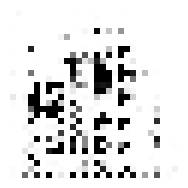

1/1 [==============================] - 0s 105ms/step


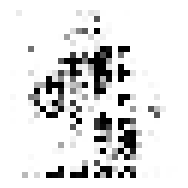

1/1 [==============================] - 0s 99ms/step


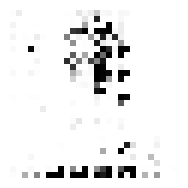

1/1 [==============================] - 0s 89ms/step


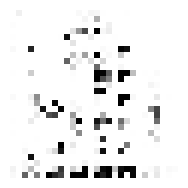

1/1 [==============================] - 0s 83ms/step


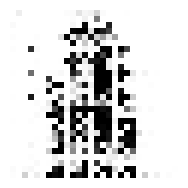

1/1 [==============================] - 0s 83ms/step


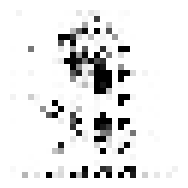

1/1 [==============================] - 0s 87ms/step


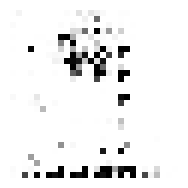

1/1 [==============================] - 0s 104ms/step


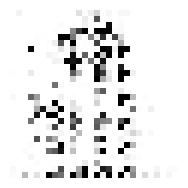

In [23]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(2, 2, 1 + i)#(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('Final_Model_25000.h5')
latent_dim = 100
n_examples = 1 # must be a square
#n_class = 0 # MBkSL
for n_class in range(8):
	# generate images
	latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
	# generate images
	X  = model.predict([latent_points, labels])
	# scale from [-1,1] to [0,1]
	X = (1-X) / 2.0
	# plot the result
	save_plot(X, n_examples)
